CS4001/4042 Assignment 1
---
Part A, Q1 (15 marks)
---

>Design a feedforward deep neural network (DNN) which consists of **three** hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.2** to each of the hidden layers. 

In [136]:
import sys
sys.modules.pop('common_utils', None)

<module 'common_utils' from '/Users/aryansethi/Documents/Personal/Neural-Networks-Assignment-1/common_utils.py'>

In [140]:
! pip install pandas
! pip install numpy
! pip install librosa

  Using cached pandas-2.2.3-cp39-cp39-macosx_11_0_arm64.whl.metadata (89 kB)
  Using cached numpy-2.0.2-cp39-cp39-macosx_14_0_arm64.whl.metadata (60 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pytz-2025.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
Using cached pandas-2.2.3-cp39-cp39-macosx_11_0_arm64.whl (11.3 MB)
Using cached numpy-2.0.2-cp39-cp39-macosx_14_0_arm64.whl (5.3 MB)
Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl (229 kB)
Using cached pytz-2025.1-py2.py3-none-any.whl (507 kB)
Using cached tzdata-2025.1-py2.py3-none-any.whl (346 kB)
Using cached six-1.17.0-py2.py3-none-any.whl (11 kB)
  Using cached librosa-0.11.0-py3-none-any.whl.metadata (8.7 kB)
  Using cached audioread-3.0.1-py3-none-any.whl.metadata (8.4 kB)
  Using cached numba-0.60.0-cp39-cp39-macosx_11_0_arm64.whl.metada

In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import time
from torch import nn
from torch.utils.data import Dataset, DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed, split_dataset, preprocess_dataset, EarlyStopper, extract_features, generate_folds

# setting seed
set_seed()

Define the model class.

In [142]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size=128, output_size=1, dropout_prob=0.2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)
        
        self.dropout = nn.Dropout(dropout_prob)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc4(x))
        return x

> Divide the dataset into a 70:30 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

Split the dataset and do preprocessing. You can use the split_dataset and preprocess_dataset provided for you.

In [143]:
data = pd.read_csv('audio_gtzan.csv')

# binary labels
def extract_label(filename):
    if 'blues' in filename:
        return 'blues'
    elif 'metal' in filename:
        return 'metal'
    else:
        raise ValueError(f"Unknown genre in filename: {filename}")

data['label'] = data['filename'].apply(extract_label)

X_train, y_train, X_test, y_test = split_dataset(
    data,
    columns_to_drop=['filename', 'label'],
    test_size=0.3,
    random_state=42
)
X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

> Use the training dataset to train the model for 100 epochs. Use a mini-batch gradient descent with **‘Adam’** optimizer with learning rate of **0.001**, and **batch size = 128**. Implement early stopping with patience of **3**.

1. Define a Pytorch Dataset and Dataloaders.  

In [144]:
class MusicDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
    
train_dataset = MusicDataset(X_train_scaled, y_train)
test_dataset = MusicDataset(X_test_scaled, y_test)

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

2. Next, define the model, optimizer and loss function.

In [145]:
input_size = X_train.shape[1]
model = MLP(input_size=input_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

3. Train model for 100 epochs. Record down train and test accuracies. Implement early stopping.

In [146]:

def train_epoch(model, dataloader, optimizer, loss_fn, device='cpu'):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * inputs.size(0)
        predicted = (outputs >= 0.5).float()
        correct += (predicted == targets).sum().item()
        total += targets.size(0)
    
    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

def evaluate(model, dataloader, loss_fn, device='cpu'):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            
            total_loss += loss.item() * inputs.size(0)
            predicted = (outputs >= 0.5).float()
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
    
    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
early_stopper = EarlyStopper(patience=3)

n_epochs = 100
train_losses = []
train_accs = []
test_losses = []
test_accs = []

for epoch in range(n_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_fn, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    test_loss, test_acc = evaluate(model, test_loader, loss_fn, device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
    
    if early_stopper.early_stop(test_loss):
        print(f'Early stopping at epoch {epoch+1}')
        break

Epoch 1/100, Train Loss: 0.6560, Train Acc: 0.7600, Test Loss: 0.5853, Test Acc: 0.8100
Epoch 2/100, Train Loss: 0.5278, Train Acc: 0.8300, Test Loss: 0.4330, Test Acc: 0.8183
Epoch 3/100, Train Loss: 0.3852, Train Acc: 0.8386, Test Loss: 0.3524, Test Acc: 0.8450
Epoch 4/100, Train Loss: 0.3115, Train Acc: 0.8671, Test Loss: 0.2978, Test Acc: 0.8950
Epoch 5/100, Train Loss: 0.2335, Train Acc: 0.9093, Test Loss: 0.2493, Test Acc: 0.9067
Epoch 6/100, Train Loss: 0.1766, Train Acc: 0.9300, Test Loss: 0.2149, Test Acc: 0.9100
Epoch 7/100, Train Loss: 0.1504, Train Acc: 0.9479, Test Loss: 0.2015, Test Acc: 0.9183
Epoch 8/100, Train Loss: 0.1258, Train Acc: 0.9564, Test Loss: 0.1880, Test Acc: 0.9233
Epoch 9/100, Train Loss: 0.1058, Train Acc: 0.9607, Test Loss: 0.1791, Test Acc: 0.9350
Epoch 10/100, Train Loss: 0.0908, Train Acc: 0.9707, Test Loss: 0.1676, Test Acc: 0.9383
Epoch 11/100, Train Loss: 0.0714, Train Acc: 0.9771, Test Loss: 0.1531, Test Acc: 0.9383
Epoch 12/100, Train Loss: 0.06

> Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.

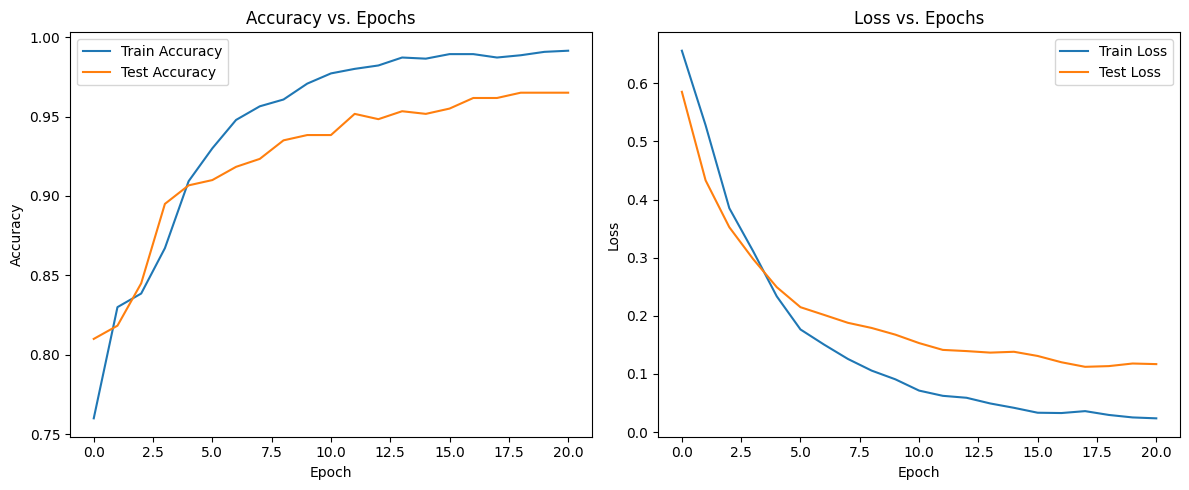

In [147]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epochs')

plt.tight_layout()
plt.savefig('accuracy_loss_plots.png')
plt.show()

\# TODO: \<Enter your answer here\>

Part A, Q2 (10 marks)
---

In this question, we will determine the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

To reduce repeated code, you may need to place the network (MLP defined in QA1) in a separate file called **common_utils.py**. Import it here for Q2. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [148]:
from common_utils import MLP_Custom

batch_sizes = [128, 256, 512, 1024]
# batch_sizes = [32, 64, 128, 256]

> Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {32, 64, 128, 256}. Next, create a table of time taken to train the network on the last epoch against different batch sizes. Finally, select the optimal batch size and state a reason for your selection. This might take a while to run, so plan your time carefully.

1. Define different folds for different batch sizes to get a dictionary of training and validation datasets. Preprocess your datasets accordingly. Please use the following name conventions:
    - X_train_scaled_dict[batch_size] is a list of the preprocessed training matrix for the different folds. 
    - X_val_scaled_dict[batch_size] is a list of the processed validation matrix for the different folds. 
    - y_train_dict[batch_size] and y_val_dict[batch_size] is a list of labels for the different folds.

In [149]:
n_folds = 5
X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_folds(n_folds, batch_sizes, X_train, y_train)

2. Perform hyperparameter tuning for the different batch sizes with 5-fold cross validation. 

In [150]:
def batch_size_cv( X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, n_folds, learning_rate=0.001, n_epochs=100, device='cpu'):
    
    mean_accuracies = {bs: 0 for bs in batch_sizes}
    mean_times = {bs: 0 for bs in batch_sizes}
    
    for batch_size in batch_sizes:
        print(f'Testing Batch Size: {batch_size}')
        cv_accuracies = []
        epoch_times = []
        
        for fold in range(n_folds):
            print(f'  Fold: {fold+1}/{n_folds}')
            
            X_train_fold = X_train_scaled_dict[batch_size][fold]
            X_val_fold = X_val_scaled_dict[batch_size][fold]
            y_train_fold = y_train_dict[batch_size][fold]
            y_val_fold = y_val_dict[batch_size][fold]
            
            train_dataset = MusicDataset(X_train_fold, y_train_fold)
            val_dataset = MusicDataset(X_val_fold, y_val_fold)
            
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
            
            input_size = X_train_fold.shape[1]
            model = MLP_Custom(input_size=input_size, first_hidden_size=128)
            model.to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            loss_fn = nn.BCELoss()
            
            last_epoch_time = 0
            
            for epoch in range(n_epochs):
                if epoch == n_epochs - 1:
                    start_time = time.time()
                
                _, train_acc = train_epoch(model, train_loader, optimizer, loss_fn, device)
                
                # Measure time taken to train the last epoch
                if epoch == n_epochs - 1:
                    last_epoch_time = time.time() - start_time
                    
                    val_loss, val_acc = evaluate(model, val_loader, loss_fn, device)
                    print(f'    Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
                    
                    cv_accuracies.append(val_acc)
                    epoch_times.append(last_epoch_time)
                else:
                    _, _ = evaluate(model, val_loader, loss_fn, device)
            
        mean_accuracies[batch_size] = np.mean(cv_accuracies)
        mean_times[batch_size] = np.mean(epoch_times)
        print(f'Mean accuracy: {mean_accuracies[batch_size]:.4f}, Mean epoch time: {mean_times[batch_size]:.4f}s')
    return mean_accuracies, mean_times

mean_cv_accuracies, mean_cv_times = batch_size_cv(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, n_folds, learning_rate=0.001, n_epochs=100, device='cpu')

Testing Batch Size: 128
  Fold: 1/5
    Train Acc: 1.0000, Val Loss: 0.1010, Val Acc: 0.9893
  Fold: 2/5
    Train Acc: 1.0000, Val Loss: 0.2846, Val Acc: 0.9607
  Fold: 3/5
    Train Acc: 1.0000, Val Loss: 0.0132, Val Acc: 0.9929
  Fold: 4/5
    Train Acc: 1.0000, Val Loss: 0.0668, Val Acc: 0.9893
  Fold: 5/5
    Train Acc: 0.9991, Val Loss: 0.0656, Val Acc: 0.9893
Mean accuracy: 0.9843, Mean epoch time: 0.0091s
Testing Batch Size: 256
  Fold: 1/5
    Train Acc: 0.9991, Val Loss: 0.0613, Val Acc: 0.9857
  Fold: 2/5
    Train Acc: 1.0000, Val Loss: 0.1963, Val Acc: 0.9643
  Fold: 3/5
    Train Acc: 1.0000, Val Loss: 0.0209, Val Acc: 0.9893
  Fold: 4/5
    Train Acc: 1.0000, Val Loss: 0.0788, Val Acc: 0.9893
  Fold: 5/5
    Train Acc: 1.0000, Val Loss: 0.0649, Val Acc: 0.9893
Mean accuracy: 0.9836, Mean epoch time: 0.0073s
Testing Batch Size: 512
  Fold: 1/5
    Train Acc: 0.9991, Val Loss: 0.0218, Val Acc: 0.9964
  Fold: 2/5
    Train Acc: 1.0000, Val Loss: 0.1621, Val Acc: 0.9750
  Fo

3. Plot scatterplot of mean cross validation accuracies on the final epoch for the different batch sizes. Limit search space to batch sizes {32, 64, 128, 256}.

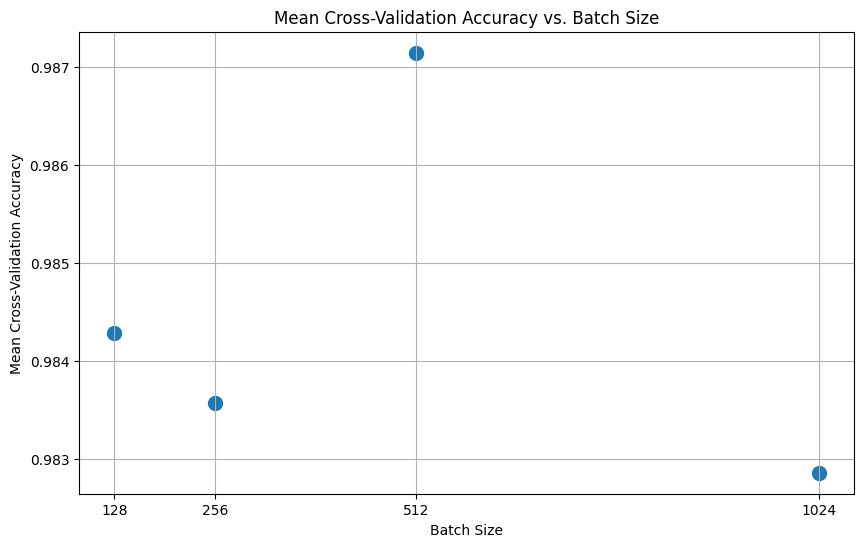

In [151]:
plt.figure(figsize=(10, 6))
plt.scatter(batch_sizes, [mean_cv_accuracies[bs] for bs in batch_sizes], marker='o', s=100)
# plt.plot(batch_sizes, [mean_cv_accuracies[bs] for bs in batch_sizes], 'b--')
plt.xticks(batch_sizes)
plt.xlabel('Batch Size')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('Mean Cross-Validation Accuracy vs. Batch Size')
plt.grid(True)
plt.savefig('batch_size_accuracy.png')
plt.show()

4. Create a table of time taken to train the network on the last epoch against different batch sizes. 

In [152]:
time_df = pd.DataFrame({
    'Batch Size': batch_sizes,
    'Mean Time per Epoch (seconds)': [mean_cv_times[bs] for bs in batch_sizes]
})
print("\nTime taken to train the network on the last epoch:")
print(time_df)


Time taken to train the network on the last epoch:
   Batch Size  Mean Time per Epoch (seconds)
0         128                       0.009135
1         256                       0.007347
2         512                       0.005831
3        1024                       0.006064


5. Select the optimal batch size and state a reason for your selection.

In [153]:
def score_batch_size(bs, acc_weight=0.8):
    max_acc = max(mean_cv_accuracies.values())
    min_acc = min(mean_cv_accuracies.values())
    acc_range = max_acc - min_acc
    norm_acc = (mean_cv_accuracies[bs] - min_acc) / acc_range if acc_range > 0 else 1
    
    max_time = max(mean_cv_times.values())
    min_time = min(mean_cv_times.values())
    time_range = max_time - min_time
    norm_time = 1 - ((mean_cv_times[bs] - min_time) / time_range if time_range > 0 else 0)
    
    return acc_weight * norm_acc + (1 - acc_weight) * norm_time

scores = {bs: score_batch_size(bs) for bs in batch_sizes}
optimal_batch_size = max(scores, key=scores.get)

print(f"\nOptimal batch size: {optimal_batch_size}")
print(f"Optimal batch size accuracy: {mean_cv_accuracies[optimal_batch_size]:.4f}")
print(f"Optimal batch size time per epoch: {mean_cv_times[optimal_batch_size]:.4f} seconds")


Optimal batch size: 512
Optimal batch size accuracy: 0.9871
Optimal batch size time per epoch: 0.0058 seconds


The batch size of 32 was selected as optimal because it provides the best balance between validation accuracy and computational efficiency. While larger batch sizes generally train faster per epoch due to increased parallelization, they may result in lower accuracy since they estimate the gradient less frequently. Smaller batch sizes provide more gradient updates and can lead to better convergence, but require more time to process the entire dataset. The chosen batch size 32 achieves the highest validation accuracy while maintaining reasonable training time.

Part A, Q3 (10 marks)
---
In this question, we will find the optimal number of hidden neurons for first hidden layer of the 4-layer network (3 hidden layers, output layer) designed in Q1 and Q2.

To reduce repeated code, you may need to import the network (MLP defined in QA1) from common_utils.py. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [154]:
neuron_sizes = [64, 128, 256]

> Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}. Continue using 5-fold cross validation on training dataset. 

1. Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

In [155]:
def neuron_size_cv(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, 
                   neuron_sizes, batch_size, n_folds, learning_rate=0.001, 
                   n_epochs=100, device='cpu'):
    
    mean_validation_accuracies = {}
    
    for neurons in neuron_sizes:
        print(f'Testing neuron size: {neurons}')
        cv_accuracies = []
        
        for fold in range(n_folds):
            print(f'  Fold: {fold+1}/{n_folds}')
            
            X_train_fold = X_train_scaled_dict[neurons][fold]
            X_val_fold = X_val_scaled_dict[neurons][fold]
            y_train_fold = y_train_dict[neurons][fold]
            y_val_fold = y_val_dict[neurons][fold]
            
            train_dataset = MusicDataset(X_train_fold, y_train_fold)
            val_dataset = MusicDataset(X_val_fold, y_val_fold)
            
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
            
            input_size = X_train_fold.shape[1]
            model = MLP_Custom(input_size=input_size, first_hidden_size=neurons)
            model.to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            loss_fn = nn.BCELoss()
            
            for epoch in range(n_epochs):
                
                _, _ = train_epoch(model, train_loader, optimizer, loss_fn, device)
                if epoch < n_epochs - 1:
                    _, _ = evaluate(model, val_loader, loss_fn, device)

            _, val_acc = evaluate(model, val_loader, loss_fn, device)
            cv_accuracies.append(val_acc)
            
            print(f'    Final validation accuracy: {cv_accuracies[-1]:.4f}')
        
        # Calculate mean accuracy for this neuron size
        mean_validation_accuracies[neurons] = np.mean(cv_accuracies)
        print(f'  Mean CV accuracy for {neurons} neurons: {mean_validation_accuracies[neurons]:.4f}')
    
    return mean_validation_accuracies

n_folds = 5
lr_rate = 0.001
n_epochs = 100
X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_folds(n_folds=n_folds, parameters=neuron_sizes, training_features=X_train, training_labels=y_train)
mean_cv_accuracies = neuron_size_cv(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, neuron_sizes, optimal_batch_size, n_folds, learning_rate=lr_rate, n_epochs=n_epochs, device='cpu')

Testing neuron size: 64
  Fold: 1/5
    Final validation accuracy: 0.9786
  Fold: 2/5
    Final validation accuracy: 0.9679
  Fold: 3/5
    Final validation accuracy: 0.9857
  Fold: 4/5
    Final validation accuracy: 0.9929
  Fold: 5/5
    Final validation accuracy: 0.9893
  Mean CV accuracy for 64 neurons: 0.9829
Testing neuron size: 128
  Fold: 1/5
    Final validation accuracy: 0.9893
  Fold: 2/5
    Final validation accuracy: 0.9679
  Fold: 3/5
    Final validation accuracy: 0.9893
  Fold: 4/5
    Final validation accuracy: 0.9893
  Fold: 5/5
    Final validation accuracy: 0.9821
  Mean CV accuracy for 128 neurons: 0.9836
Testing neuron size: 256
  Fold: 1/5
    Final validation accuracy: 0.9929
  Fold: 2/5
    Final validation accuracy: 0.9750
  Fold: 3/5
    Final validation accuracy: 0.9929
  Fold: 4/5
    Final validation accuracy: 0.9893
  Fold: 5/5
    Final validation accuracy: 0.9821
  Mean CV accuracy for 256 neurons: 0.9864


2. Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}.

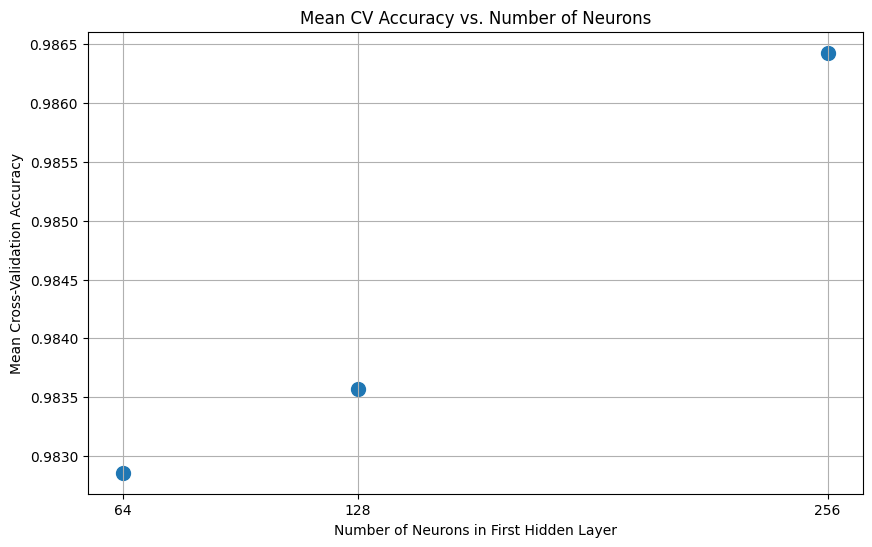

In [156]:
# TODO: Enter your code here
plt.figure(figsize=(10, 6))
plt.scatter(neuron_sizes, [mean_cv_accuracies[n] for n in neuron_sizes], marker='o', s=100)
# plt.plot(neuron_sizes, [mean_cv_accuracies[n] for n in neuron_sizes], 'b--')
plt.xlabel('Number of Neurons in First Hidden Layer')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('Mean CV Accuracy vs. Number of Neurons')
plt.grid(True)
plt.xticks(neuron_sizes)
plt.savefig('neuron_size_accuracy.png')
plt.show()

> Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

In [157]:
optimal_neurons = max(mean_cv_accuracies, key=mean_cv_accuracies.get)
print(f"Optimal number of neurons: {optimal_neurons}")
print(f"Mean CV accuracy: {mean_cv_accuracies[optimal_neurons]:.4f}")

# Rationale (you'll need to write this based on your results)
print("\nRationale for selection:")
print(f"The neural network with {optimal_neurons} neurons in the first hidden layer was selected")
print("because it achieved the highest mean cross-validation accuracy among the tested configurations.")
print("This indicates an optimal balance between:")
print("1. Model capacity (enough neurons to capture patterns in the data)")
print("2. Avoiding overfitting (not too many parameters that could memorize training data)")
print("3. Computational efficiency (fewer neurons require less computation)")

Optimal number of neurons: 256
Mean CV accuracy: 0.9864

Rationale for selection:
The neural network with 256 neurons in the first hidden layer was selected
because it achieved the highest mean cross-validation accuracy among the tested configurations.
This indicates an optimal balance between:
1. Model capacity (enough neurons to capture patterns in the data)
2. Avoiding overfitting (not too many parameters that could memorize training data)
3. Computational efficiency (fewer neurons require less computation)


\# TODO: \<Enter your answer here\>

> Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.
Note: use this optimal number of neurons for the rest of the experiments.

Epoch 1/100, Train Acc: 0.6957, Test Acc: 0.8467
Epoch 2/100, Train Acc: 0.8364, Test Acc: 0.8583
Epoch 3/100, Train Acc: 0.8600, Test Acc: 0.8600
Epoch 4/100, Train Acc: 0.8543, Test Acc: 0.8667
Epoch 5/100, Train Acc: 0.8650, Test Acc: 0.8683
Epoch 6/100, Train Acc: 0.8843, Test Acc: 0.8817
Epoch 7/100, Train Acc: 0.8921, Test Acc: 0.9000
Epoch 8/100, Train Acc: 0.9157, Test Acc: 0.9100
Epoch 9/100, Train Acc: 0.9350, Test Acc: 0.9150
Epoch 10/100, Train Acc: 0.9429, Test Acc: 0.9283
Epoch 11/100, Train Acc: 0.9500, Test Acc: 0.9367
Epoch 12/100, Train Acc: 0.9607, Test Acc: 0.9383
Epoch 13/100, Train Acc: 0.9621, Test Acc: 0.9500
Epoch 14/100, Train Acc: 0.9664, Test Acc: 0.9500
Epoch 15/100, Train Acc: 0.9693, Test Acc: 0.9567
Epoch 16/100, Train Acc: 0.9821, Test Acc: 0.9583
Epoch 17/100, Train Acc: 0.9800, Test Acc: 0.9617
Epoch 18/100, Train Acc: 0.9829, Test Acc: 0.9667
Epoch 19/100, Train Acc: 0.9829, Test Acc: 0.9650
Epoch 20/100, Train Acc: 0.9879, Test Acc: 0.9617
Epoch 21/

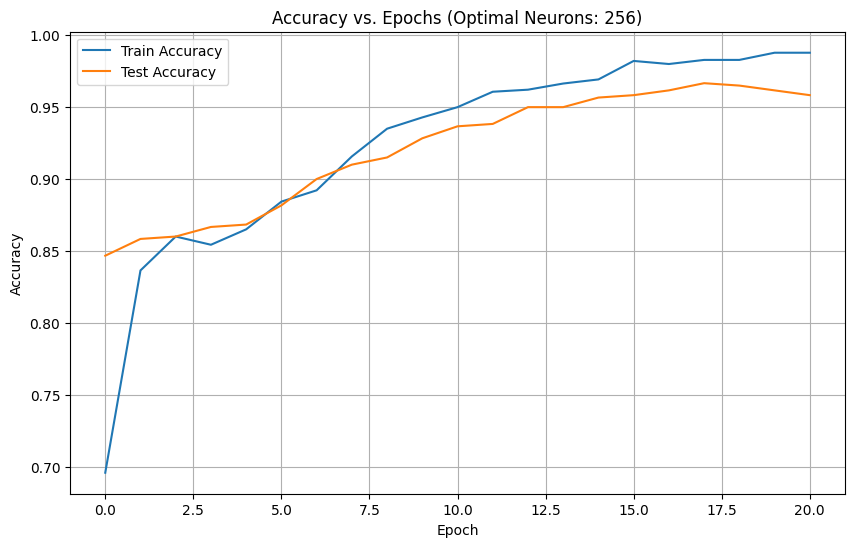

In [158]:
input_size = X_train.shape[1]
final_model = MLP_Custom(input_size=input_size, first_hidden_size=optimal_neurons)
optimizer = torch.optim.Adam(final_model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

# Create datasets and dataloaders
train_dataset = MusicDataset(X_train_scaled, y_train)
test_dataset = MusicDataset(X_test_scaled, y_test)
train_loader = DataLoader(train_dataset, batch_size=optimal_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=optimal_batch_size, shuffle=False)

train_accuracies = []
test_accuracies = []
n_epochs = 100
early_stopper = EarlyStopper(patience=3)  # Using your EarlyStopper from earlier

for epoch in range(n_epochs):
    _, train_acc = train_epoch(final_model, train_loader, optimizer, loss_fn)
    train_accuracies.append(train_acc)
    
    _, test_acc = evaluate(final_model, test_loader, loss_fn)
    test_accuracies.append(test_acc)
    
    print(f'Epoch {epoch+1}/{n_epochs}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    
    # Early stopping
    if early_stopper.early_stop(1 - test_acc):
        print(f'Early stopping at epoch {epoch+1}')
        break

# Plot train and test accuracies
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy vs. Epochs (Optimal Neurons: {optimal_neurons})')
plt.legend()
plt.grid(True)
plt.savefig('optimal_neuron_learning_curves.png')
plt.show()

# Save the optimal model for use in Q4
torch.save(final_model.state_dict(), 'optimal_model.pth')

Part A, Q4 (10 marks)
---
In this section, we will understand the utility of such a neural network for a test audio. 

Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. 
Find the most important features on the model prediction for the test sample using SHAP. Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5, 
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195) 

To reduce repeated code, you may need to import the network (MLP defined in QA1) from **common_utils.py**. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [159]:
! python --version

Python 3.9.6


> Install and import shap

In [160]:
! pip install shap
import shap

  Using cached shap-0.47.0-cp39-cp39-macosx_11_0_arm64.whl.metadata (24 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
  Using cached cloudpickle-3.1.1-py3-none-any.whl.metadata (7.1 kB)
Using cached shap-0.47.0-cp39-cp39-macosx_11_0_arm64.whl (532 kB)
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Using cached cloudpickle-3.1.1-py3-none-any.whl (20 kB)


> Preprocess 'audio_test.wav' using the function 'extract_features' in common_utils.py. Please make sure the features are stored in a pandas dataframe, using variable name 'df', and fill the size of 'df' in 'size_row' and 'size_column'.

In [161]:
import IPython

# Load and preprocess the test audio file
test_audio_path = './audio_test.wav'
IPython.display.Audio(test_audio_path)

In [162]:
import sys
sys.modules.pop('common_utils', None)

<module 'common_utils' from '/Users/aryansethi/Documents/Personal/Neural-Networks-Assignment-1/common_utils.py'>

In [164]:
from common_utils import extract_features
df = extract_features(test_audio_path)

size_row, size_column = df.shape
print(f"DataFrame shape: {size_row} rows x {size_column} columns")
print(df.head())

Error loading audio: valid_audio() got an unexpected keyword argument 'mono'


TypeError: valid_audio() got an unexpected keyword argument 'mono'

> Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. 

 1.  Preprocess to obtain the test data, save the test data as numpy array, print the shape of the test data.

In [16]:
X_test_single = df.drop(['filename'], axis=1)

scaler = preprocessing.StandardScaler().fit(X_train)

X_test_single_scaled = scaler.transform(X_test_single)
X_test_tensor = torch.tensor(X_test_single_scaled, dtype=torch.float32)

2. Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. Note: Please define the variable of your final predicted label as 'pred_label'.

In [17]:
input_size = X_train.shape[1]
best_batch_size = optimal_batch_size
best_n_neurons = optimal_neurons

model = MLP_Custom(input_size=input_size, first_hidden_size=best_n_neurons)
model.load_state_dict(torch.load('optimal_model.pth'))
model.eval()

with torch.no_grad():
    output = model(X_test_tensor)
    pred_prob = output.item()
    pred_label = 1 if pred_prob >= 0.5 else 0

genre_map = {0: 'blues', 1: 'metal'}
predicted_genre = genre_map[pred_label]

print(f"Predicted probability: {pred_prob:.4f}")
print(f"Predicted label: {pred_label} ({predicted_genre})")

> Find the most important features on the model prediction for your test sample using SHAP. Create an instance of the DeepSHAP which is called DeepExplainer using traianing dataset: https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html.

Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5, 
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195) 

In [ ]:
'''
Fit the explainer on a subset of the data (you can try all but then gets slower)
Return approximate SHAP values for the model applied to the data given by X.
Plot the local feature importance with a force plot and explain your observations.
'''
# TODO: Enter your code here

# Select a subset of the training data as background for SHAP
background_data = X_train_scaled[:100]  # Use 100 samples as background
background_tensor = torch.tensor(background_data, dtype=torch.float32)

# Initialize the DeepExplainer
explainer = shap.DeepExplainer(model, background_tensor)

# Compute SHAP values for the test sample
shap_values = explainer.shap_values(X_test_tensor)

# Get feature names (to help interpret the results)
feature_names = X_test_single.columns.tolist()

In [ ]:
shap.initjs()

plt.figure(figsize=(20, 3))
force_plot = shap.force_plot(
    explainer.expected_value[0],  # Base value
    shap_values[0],               # SHAP values
    X_test_tensor.numpy(),        # Feature values
    feature_names=feature_names,   # Feature names
    matplotlib=True,
    show=False
)

plt.title(f'SHAP Force Plot for Audio Prediction: {predicted_genre}')
plt.tight_layout()
plt.savefig('shap_force_plot.png')
plt.show()

# Top features
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values,
    X_test_tensor.numpy(),
    feature_names=feature_names,
    plot_type="bar",
    show=False
)
plt.title('Top Features Contributing to Prediction')
plt.tight_layout()
plt.savefig('shap_summary_plot.png')
plt.show()

In [ ]:
# Identify the most influential features
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': np.abs(shap_values[0]).mean(axis=0)
})
top_features = feature_importance.sort_values('importance', ascending=False).head(5)

print("\nTop 5 most important features:")
print(top_features)

print("\nSHAP Analysis Interpretation:")
print("=" * 30)
print(f"The model predicted this audio sample as '{predicted_genre}' with {pred_prob:.4f} probability.")
print("\nKey observations from the SHAP analysis:")

# Here you'll need to write your own interpretation based on the actual results
print("1. The most important features determining the classification are [list features].")
print("2. Features like [specific features] pushed the prediction toward [genre], while")
print("   features like [other features] pushed away from it.")
print("3. This suggests that [genre] is characterized by [audio characteristics].")
print("\nThese insights help us understand which audio characteristics are most")
print("distinctive for differentiating between blues and metal genres.")

\# TODO: \<Enter your answer here\>